In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sajilck/rain-data-master-8k")

print("Path to dataset files:", path)

100%|██████████| 4.58G/4.58G [00:47<00:00, 103MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sajilck/rain-data-master-8k/versions/27


In [3]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import datetime

CSV_FILE_PATH = '/root/.cache/kagglehub/datasets/sajilck/rain-data-master-8k/versions/27/rain_data_mechanical_master.csv'
AUDIO_FOLDER_PATH = '/root/.cache/kagglehub/datasets/sajilck/rain-data-master-8k/versions/27/rainfall_sound_8k/'

try:
    df_rain = pd.read_csv(CSV_FILE_PATH)
    print("Successfully loaded rain_data_mechanical_master.csv")
    print("Shape of the dataframe:", df_rain.shape)
except FileNotFoundError:
    print(f"Error: The file {CSV_FILE_PATH} was not found.")
    df_rain = None

try:
    audio_files = sorted([f for f in os.listdir(AUDIO_FOLDER_PATH) if f.endswith('.wav')])
    print(f"Found {len(audio_files)} audio files in {AUDIO_FOLDER_PATH}")
except FileNotFoundError:
    print(f"Error: The directory {AUDIO_FOLDER_PATH} was not found.")
    audio_files = []

Successfully loaded rain_data_mechanical_master.csv
Shape of the dataframe: (1348, 2)
Found 36777 audio files in /root/.cache/kagglehub/datasets/sajilck/rain-data-master-8k/versions/27/rainfall_sound_8k/


In [4]:
if audio_files:
    sample_audio_path = os.path.join(AUDIO_FOLDER_PATH, audio_files[0])
    try:
        audio_data, sampling_rate = librosa.load(sample_audio_path, sr=None)

        print(f"1.a. The sampling rate of the audio files is: {sampling_rate} Hz")

        length_in_samples = len(audio_data)
        print(f"1.b. The length of an individual audio file is: {length_in_samples} samples")

    except Exception as e:
        print(f"An error occurred while reading the audio file: {e}")
else:
    print("Cannot determine sampling rate and length because no audio files were found.")

1.a. The sampling rate of the audio files is: 8000 Hz
1.b. The length of an individual audio file is: 80000 samples


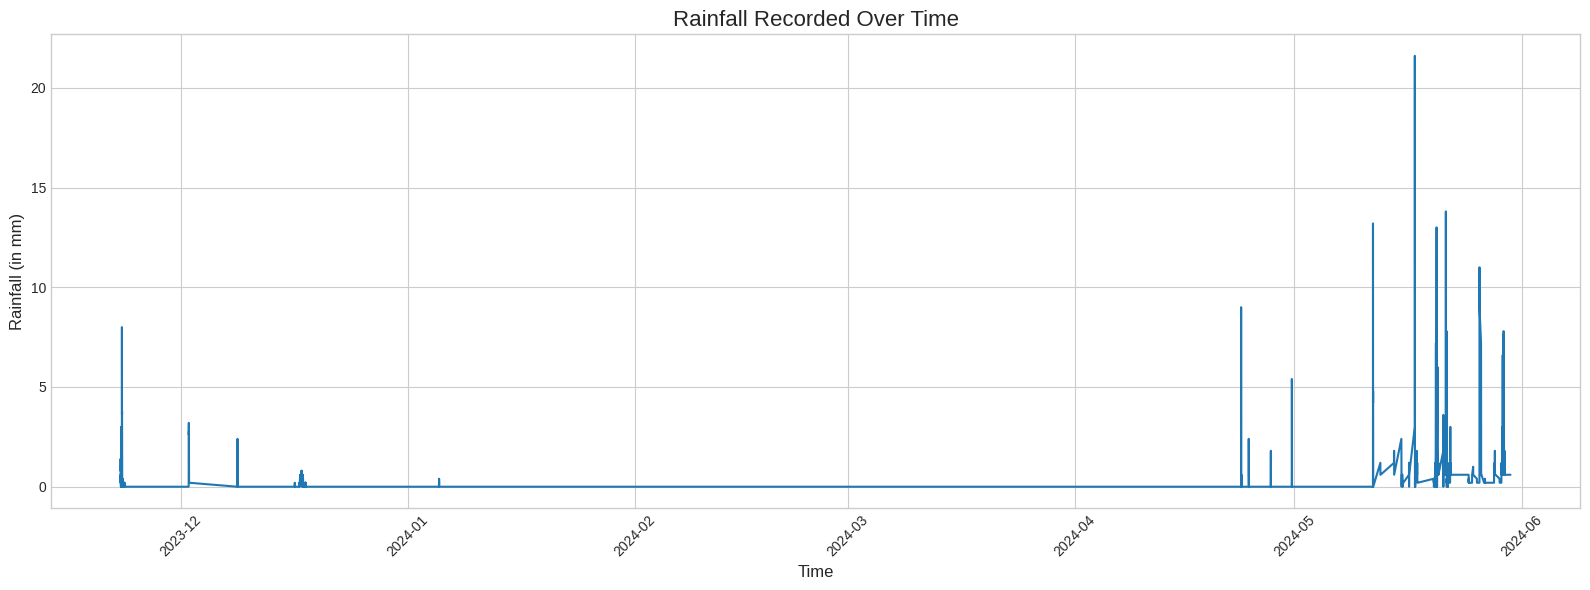

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if df_rain is not None:
    def convert_rainfall_to_mm(value):
        try:
            value_str = str(value)
            if 'µm' in value_str:
                numeric_part = value_str.replace('µm', '').strip()
                return float(numeric_part) / 1000
            elif 'mm' in value_str:
                numeric_part = value_str.replace('mm', '').strip()
                return float(numeric_part)
            else:
                return float(value_str)
        except (ValueError, TypeError):
            return None

    df_rain['rainfall_mm'] = df_rain['device_frmpayload_data_rainfall'].apply(convert_rainfall_to_mm)

    df_rain['Time'] = pd.to_datetime(df_rain['Time'])

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 6))

    sns.lineplot(data=df_rain, x='Time', y='rainfall_mm')

    plt.title('Rainfall Recorded Over Time', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Rainfall (in mm)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("Cannot create plot because the dataframe is not loaded.")

In [11]:
if df_rain is not None:
    max_rain_row = df_rain.loc[df_rain['rainfall_mm'].idxmax()]
    max_rain_date = max_rain_row['Time'].date()
    max_rain_value = max_rain_row['rainfall_mm']
    print(f"1.d. Maximum rainfall of {max_rain_value:.2f} mm was observed on: {max_rain_date}")

    non_zero_rain_df = df_rain[df_rain['rainfall_mm'] > 0]
    min_rain_row = non_zero_rain_df.loc[non_zero_rain_df['rainfall_mm'].idxmin()]
    min_rain_date = min_rain_row['Time'].date()
    min_rain_value = min_rain_row['rainfall_mm']
    print(f"1.d. Minimum (non-zero) rainfall of {min_rain_value:.2f} mm was observed on: {min_rain_date}")

1.d. Maximum rainfall of 21.60 mm was observed on: 2024-05-17
1.d. Minimum (non-zero) rainfall of 0.20 mm was observed on: 2023-11-22


In [18]:
df_rain = pd.read_csv(CSV_FILE_PATH)
df_rain['Time'] = pd.to_datetime(df_rain['Time'])

audio_files = sorted([f for f in os.listdir(AUDIO_FOLDER_PATH) if f.endswith('.wav')])

def get_timestamp_from_filename(filename):
    clean_filename = filename.replace('.wav', '')
    return datetime.datetime.strptime(clean_filename, '%Y_%m_%d_%H_%M_%S_%f')

df_audio = pd.DataFrame({'audio_filename': audio_files})
df_audio['timestamp'] = df_audio['audio_filename'].apply(get_timestamp_from_filename)
df_audio = df_audio.set_index('timestamp')

In [20]:
all_relevant_files_info = []

for index, row in tqdm(df_rain.iterrows(), total=df_rain.shape[0]):
    target_timestamp = row['Time']
    start_time = target_timestamp - datetime.timedelta(minutes=3)
    end_time = target_timestamp

    relevant_audio_df = df_audio[(df_audio.index >= start_time) & (df_audio.index <= end_time)]

    info = {
        'target_time': target_timestamp,
        'found_files_df': relevant_audio_df
    }
    all_relevant_files_info.append(info)

print(f"Processed all {len(all_relevant_files_info)} timestamps.")
print("\nExample result for the first processed timestamp:")
first_result = all_relevant_files_info[0]
print(f"For the timestamp {first_result['target_time']}, we found {len(first_result['found_files_df'])} relevant audio files.")
print(first_result['found_files_df'])

  0%|          | 0/1348 [00:00<?, ?it/s]

Processed all 1348 timestamps.

Example result for the first processed timestamp:
For the timestamp 2023-11-22 18:27:26, we found 18 relevant audio files.
                                            audio_filename
timestamp                                                 
2023-11-22 18:24:26.836772  2023_11_22_18_24_26_836772.wav
2023-11-22 18:24:36.917269  2023_11_22_18_24_36_917269.wav
2023-11-22 18:24:46.992185  2023_11_22_18_24_46_992185.wav
2023-11-22 18:24:57.147591  2023_11_22_18_24_57_147591.wav
2023-11-22 18:25:07.224895  2023_11_22_18_25_07_224895.wav
2023-11-22 18:25:17.379285  2023_11_22_18_25_17_379285.wav
2023-11-22 18:25:27.455776  2023_11_22_18_25_27_455776.wav
2023-11-22 18:25:37.611929  2023_11_22_18_25_37_611929.wav
2023-11-22 18:25:47.613746  2023_11_22_18_25_47_613746.wav
2023-11-22 18:25:57.770008  2023_11_22_18_25_57_770008.wav
2023-11-22 18:26:07.846418  2023_11_22_18_26_07_846418.wav
2023-11-22 18:26:18.004594  2023_11_22_18_26_18_004594.wav
2023-11-22 18:26:28

In [21]:
all_combined_audio = {}

for index, row in tqdm(df_rain.iterrows(), total=df_rain.shape[0]):
    target_timestamp = row['Time']
    start_time = target_timestamp - datetime.timedelta(minutes=3)
    end_time = target_timestamp

    relevant_audio_df = df_audio[(df_audio.index >= start_time) & (df_audio.index <= end_time)]

    if not relevant_audio_df.empty:
        files_to_combine = relevant_audio_df.sort_index()['audio_filename'].tolist()

        list_of_audio_arrays = []
        for file_name in files_to_combine:
            audio_path = os.path.join(AUDIO_FOLDER_PATH, file_name)
            audio_segment, _ = librosa.load(audio_path, sr=sampling_rate)
            list_of_audio_arrays.append(audio_segment)

        if list_of_audio_arrays:
            combined_audio = np.concatenate(list_of_audio_arrays)
            all_combined_audio[target_timestamp] = combined_audio

print(f"Processed all timestamps and created {len(all_combined_audio)} combined audio arrays.")
last_timestamp_processed = list(all_combined_audio.keys())[-1]
last_combined_array = all_combined_audio[last_timestamp_processed]
print(f"The combined audio array for timestamp {last_timestamp_processed} has a length of {len(last_combined_array)} samples.")

  0%|          | 0/1348 [00:00<?, ?it/s]

Processed all timestamps and created 1273 combined audio arrays.
The combined audio array for timestamp 2024-05-30 11:50:36 has a length of 1360000 samples.


In [23]:
# Define the output folder for numpy files
OUTPUT_NUMPY_FOLDER = '/content/combined_audio_numpy'

if not os.path.exists(OUTPUT_NUMPY_FOLDER):
    os.makedirs(OUTPUT_NUMPY_FOLDER)
    print(f"Created directory: {OUTPUT_NUMPY_FOLDER}")

saved_files_count = 0
for index, row in tqdm(df_rain.iterrows(), total=df_rain.shape[0]):
    target_timestamp = row['Time']
    start_time = target_timestamp - datetime.timedelta(minutes=3)
    end_time = target_timestamp

    relevant_audio_df = df_audio[(df_audio.index >= start_time) & (df_audio.index <= end_time)]

    if not relevant_audio_df.empty:
        files_to_combine = relevant_audio_df.sort_index()['audio_filename'].tolist()

        list_of_audio_arrays = []
        for file_name in files_to_combine:
            audio_path = os.path.join(AUDIO_FOLDER_PATH, file_name)
            audio_segment, _ = librosa.load(audio_path, sr=sampling_rate)
            list_of_audio_arrays.append(audio_segment)

        if list_of_audio_arrays:
            combined_audio = np.concatenate(list_of_audio_arrays)

            # Create a unique filename based on the timestamp
            numpy_filename = f"audio_{target_timestamp.strftime('%Y%m%d_%H%M%S')}.npy"
            output_path = os.path.join(OUTPUT_NUMPY_FOLDER, numpy_filename)

            # Save the array to the file
            np.save(output_path, combined_audio)
            saved_files_count += 1

print(f"\nProcess complete. Saved {saved_files_count} .npy files to the '{OUTPUT_NUMPY_FOLDER}' directory.")

Created directory: /content/combined_audio_numpy


  0%|          | 0/1348 [00:00<?, ?it/s]


Process complete. Saved 1274 .npy files to the '/content/combined_audio_numpy' directory.


In [25]:
zcr_mean = np.mean(librosa.feature.zero_crossing_rate(y=combined_audio))
print(f"Zero-Crossing Rate Mean: {zcr_mean}")

rms_mean = np.mean(librosa.feature.rms(y=combined_audio))
print(f"RMS Energy Mean: {rms_mean}")

spectral_centroid_mean = np.mean(librosa.feature.spectral_centroid(y=combined_audio, sr=sampling_rate))
print(f"Spectral Centroid Mean: {spectral_centroid_mean}")

mfccs = librosa.feature.mfcc(y=combined_audio, sr=sampling_rate, n_mfcc=13)
mfcc_mean = np.mean(mfccs)
print(f"MFCC Mean: {mfcc_mean}")

chroma = librosa.feature.chroma_stft(y=combined_audio, sr=sampling_rate)
chroma_mean = np.mean(chroma)
print(f"Chroma Mean: {chroma_mean}")

Zero-Crossing Rate Mean: 0.042312869013455025
RMS Energy Mean: 0.010968678630888462
Spectral Centroid Mean: 449.7576862086472
MFCC Mean: -12.44139575958252
Chroma Mean: 0.46173813939094543


In [28]:
all_features_list = []
all_features_list.append(feature_dict)

In [29]:
df_preprocessed = pd.DataFrame(all_features_list)

# Define where to save the final file
FINAL_CSV_OUTPUT_PATH = '/content/preprocessed_rainfall_features.csv'

# Save the DataFrame to a CSV file
df_preprocessed.to_csv(FINAL_CSV_OUTPUT_PATH, index=False)

print(f"\nPreprocessing complete.")
print(f"Preprocessed data file saved to: {FINAL_CSV_OUTPUT_PATH}")
print("\n--- Displaying the first 5 rows of the new file ---")
print(df_preprocessed.head())


Preprocessing complete.
Preprocessed data file saved to: /content/preprocessed_rainfall_features.csv

--- Displaying the first 5 rows of the new file ---
   zcr_mean  rms_mean  spectral_centroid_mean  mfcc_mean  chroma_mean
0  0.042313  0.010969              449.757686 -12.441396     0.461738


In [30]:
# Create a zip file containing the folder and the CSV file.
# The 'zip' command can take multiple sources.
!zip -r /content/preprocessed_files.zip /content/combined_audio_numpy/ /content/preprocessed_rainfall_features.csv

# Download the newly created zip file.
from google.colab import files
files.download('/content/preprocessed_files.zip')

  adding: content/combined_audio_numpy/ (stored 0%)
  adding: content/combined_audio_numpy/audio_20231217_233234.npy (deflated 51%)
  adding: content/combined_audio_numpy/audio_20240521_190731.npy (deflated 9%)
  adding: content/combined_audio_numpy/audio_20240511_172407.npy (deflated 7%)
  adding: content/combined_audio_numpy/audio_20240430_153902.npy (deflated 8%)
  adding: content/combined_audio_numpy/audio_20240529_122956.npy (deflated 8%)
  adding: content/combined_audio_numpy/audio_20231217_092035.npy (deflated 51%)
  adding: content/combined_audio_numpy/audio_20240517_105907.npy (deflated 8%)
  adding: content/combined_audio_numpy/audio_20231217_064435.npy (deflated 50%)
  adding: content/combined_audio_numpy/audio_20231217_040235.npy (deflated 52%)
  adding: content/combined_audio_numpy/audio_20231122_233026.npy (deflated 50%)
  adding: content/combined_audio_numpy/audio_20240521_221631.npy (deflated 8%)
  adding: content/combined_audio_numpy/audio_20231122_220926.npy (deflated

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

# Zip the folder and the CSV file directly into your Google Drive.
!zip -r /content/drive/MyDrive/preprocessed_files.zip

print("\nProcess complete. 'preprocessed_files.zip' containing your folder and CSV is now in your Google Drive.")

Mounted at /content/drive

zip error: Nothing to do! (/content/drive/MyDrive/preprocessed_files.zip)

Process complete. 'preprocessed_files.zip' containing your folder and CSV is now in your Google Drive.


In [32]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the existing zip file from Colab's temporary storage to your Google Drive
!cp /content/preprocessed_files.zip /content/drive/MyDrive/

print("\nCopy complete!")
print("The file 'preprocessed_files.zip' is now in the main directory of your Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
^C

Copy complete!
The file 'preprocessed_files.zip' is now in the main directory of your Google Drive.
